# Group Project

## Importing the Relevant Libraries

In [ ]:
# Importing relevant libraries
!pip install shap

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import seaborn as sns
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap.umap_ as umap
import gc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import shap

def optimize_df(df):
    for col in df.select_dtypes(include=["float"]):
        df[col] = pd.to_numeric(df[col], downcast="float")
    for col in df.select_dtypes(include=["int"]):
        df[col] = pd.to_numeric(df[col], downcast="integer")
    for col in df.select_dtypes(include=["object"]):
        if df[col].nunique() / len(df[col]) < 0.5:
            df[col] = df[col].astype("category")
    return df


c:\Users\chris\OneDrive\Desktop\VSCode\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Downloading the Datasets

In [ ]:
!gdown --fuzzy "https://drive.google.com/file/d/1LK6liE-fpHF132yifU2u1-YlsGBHsI8p/view?usp=drive_link"
!gdown --fuzzy "https://drive.google.com/file/d/1v7RD_qFC0J2xVL0z9lr0OV_xxrmYjCh_/view?usp=sharing"

Downloading...
From (original): https://drive.google.com/uc?id=1LK6liE-fpHF132yifU2u1-YlsGBHsI8p
From (redirected): https://drive.google.com/uc?id=1LK6liE-fpHF132yifU2u1-YlsGBHsI8p&confirm=t&uuid=3fe0b727-6bfb-4f19-8800-c62ebfdb8331
To: /content/DemoStats.csv
100% 1.43G/1.43G [00:16<00:00, 88.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1v7RD_qFC0J2xVL0z9lr0OV_xxrmYjCh_
From (redirected): https://drive.google.com/uc?id=1v7RD_qFC0J2xVL0z9lr0OV_xxrmYjCh_&confirm=t&uuid=1105a032-9a1c-4293-99e5-5add27bab601
To: /content/HouseholdSpend.csv
100% 3.17G/3.17G [00:42<00:00, 74.9MB/s]


## Data Loading

In [ ]:
# Loading Data
chunks = []
chunk_size = 100_000
reader = pd.read_csv("HouseholdSpend.csv", chunksize=chunk_size)


for i, chunk in enumerate(reader):
    print(f"Processing HouseholdSpend chunk {i + 1}")
    chunk = chunk.sample(frac=0.1, random_state=42)
    chunks.append(chunk)

household_spending = pd.concat(chunks)
household_spending.to_parquet("HouseholdSpend_sampled.parquet", index=False)

household_spending = pd.read_parquet("HouseholdSpend_sampled.parquet")

chunks = []
chunk_size = 100_000
reader = pd.read_csv("DemoStats.csv", chunksize=chunk_size)

for i, chunk in enumerate(reader):
    print(f"Processing DemoStats chunk {i + 1}")
    chunk = chunk.sample(frac=0.1, random_state=42)
    chunks.append(chunk)

demo_stats = pd.concat(chunks)
demo_stats.to_parquet("DemoStats_sampled.parquet", index=False)

demo_stats = pd.read_parquet("DemoStats_sampled.parquet")

Processing HouseholdSpend chunk 1
Processing HouseholdSpend chunk 2
Processing HouseholdSpend chunk 3
Processing HouseholdSpend chunk 4
Processing HouseholdSpend chunk 5
Processing HouseholdSpend chunk 6
Processing HouseholdSpend chunk 7
Processing HouseholdSpend chunk 8
Processing HouseholdSpend chunk 9
Processing DemoStats chunk 1
Processing DemoStats chunk 2
Processing DemoStats chunk 3
Processing DemoStats chunk 4
Processing DemoStats chunk 5
Processing DemoStats chunk 6
Processing DemoStats chunk 7
Processing DemoStats chunk 8
Processing DemoStats chunk 9


## 1. a) Data Cleaning

#### (I) Dropping the "pension" and "premium insurance" related column(s) from HouseholdSpend.csv

In [ ]:
# The only columns in HouseholdSpend.csv regarding pension and premium insurance, to exclude
cols_to_drop = ["HSEP001S", "HSSH006", "HSSH015", "HSSH019", "HSHC022", "HSHC023", "HSHC024", "HSHC025", "HSTR032",]
household_spending = household_spending.drop(columns=cols_to_drop)

#### (II) Dropping the columns consisting of only 0's  as they have no variance and provide no valuable information, which could negatively affect clustering and model results if kept.

In [ ]:
# Drops the columns that consists of only 0's. If there are no such columns, it does not drop anything
def drop_col_all_zeroes(dataset, nameOfDataset):
    for col in dataset.columns:

        # Only checks the numerical columns
        if col not in ["CODE", "GEO"] and(dataset[col] == 0).all() == True:
            print(f"In dataset {nameOfDataset}, the columns with only 0s: {col}")
            dataset = dataset.drop(columns=[col])

    return dataset

household_spending = drop_col_all_zeroes(household_spending, "HouseholdSpend")
demo_stats = drop_col_all_zeroes(demo_stats, "DemoStats")

In dataset DemoStats, the columns with only 0s: ECYASQKM
In dataset DemoStats, the columns with only 0s: ECYALSQKM


#### (III) Dealing with invalid outliers

In [ ]:
# Finds the negative values of the columns in the datasets
def find_invalid_outliers(dataset, nameOfDataset):
    for col in dataset:

        # Only checks the numerical columns
        if col not in ["CODE", "GEO"] and dataset[col].min() < 0:
            print(f"In Dataset {nameOfDataset}, Column {col}, Count: {dataset[col][dataset[col] < 0].count()}")

find_invalid_outliers(household_spending, "HouseholdSpend")
find_invalid_outliers(demo_stats, "DemoStats")

In Dataset HouseholdSpend, Column HSTT001, Count: 3
In Dataset HouseholdSpend, Column HSTE001ZBS, Count: 16291
In Dataset HouseholdSpend, Column HSWH040S, Count: 25593
In Dataset HouseholdSpend, Column HSWH041S, Count: 1547
In Dataset HouseholdSpend, Column HSWH042S, Count: 1844


- Column HSTT001: Stores information about the "Total Expenditure" of households. Since total expenditure of households cannot be negative (it being negative means that there was a refund, which should not be counted as an expense), any row with the invalid outlier should be removed.

- Column HSTE001ZBS: Stores information about the "Total non-current consumption" of households. It involves major householld purchases, like homes, vehicles, renovations, etc... Negative values could represent capital gains/losses, so do not delete the rows contianing negative values.

- Columns HSWH040S, HSWH041S, and HSWH042S: Store information about the "Net" purchase price of properties or residences. Since "Net" is typically a difference between total spending and refunds, sales, or returns, negative values are expected. So, keep the rows with negative values in those columns.

In [ ]:
# Removing the rows with a negative value under the HSTT001 columns in the HouseholdSpend dataset
household_spending = household_spending[household_spending["HSTT001"] >= 0]

#### (IV) Since the HouseholdSpend dataset does not contain any null values, and since the DemoStats dataset does contain null values, they need tp be handled. After checking how many null values each column of the DemoStats dataset has, it shows that only the columns storing data about the median ages of various kinds of populations store null values. The number of null values of the given columns are not too small, however, since they are important, replacing is a better option than deleting. Since Age is continuous, the null values will be replaced with the median of their respective columns.

In [ ]:
# Find the columns that contain null values
null_columns_household = household_spending.isna().sum()
household_null_col_list = list(null_columns_household[null_columns_household > 0].index) # Makes a list of all the  columns containing null values
print("HouseholdSpend Dataset - columns that contain null values:")
print(household_null_col_list)

print("\n")

null_columns_demo = demo_stats.isna().sum()
demo_null_col_list = list(null_columns_demo[null_columns_demo > 0].index) # Makes a list of all the  columns containing null values
print("DemoStats Dataset - columns that contain null values:")
print(demo_null_col_list)

HouseholdSpend Dataset - columns that contain null values:
[]


DemoStats Dataset - columns that contain null values:
['ECYPTAMED', 'ECYPMAMED', 'ECYPFAMED', 'ECYHTAMED', 'ECYHMAMED', 'ECYHFAMED', 'ECYMTNMED']


In [ ]:
# Replacing the null values with median
columns_to_modify = ["ECYPTAMED", "ECYPMAMED", "ECYPFAMED", "ECYHTAMED", "ECYHMAMED", "ECYHFAMED", "ECYMTNMED"]

for col in columns_to_modify:
    median = demo_stats[col].median()
    demo_stats[col] = demo_stats[col].fillna(median)

#### (V) Removes the rows containing extreme outliers using z-score to improve cluster efficiency

In [ ]:
def find_and_remove_outliers(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns # Gets the numerical columns of the dataset so that the ID columns are ignored
    df = df[(np.abs(stats.zscore(df[numeric_cols])) < 3).all(axis=1)]# Uses z-score to find and remove outliers when their z-score is not within 3 standard deviations of the mean

    return df

household_spending = find_and_remove_outliers(household_spending)
demo_stats = find_and_remove_outliers(demo_stats)

#### (VI) Merging both datasets on the "CODE" and "GEO" columns

In [ ]:
merged_df = pd.merge(household_spending, demo_stats, on=["CODE", "GEO"], how="inner")


#### (VII) Cleaning the merged dataset

In [ ]:
# Dropping the IDs since they are the only non numerical columns and should not contribute to the cluster analysis
numerical_merged_df = merged_df.drop(columns=["CODE", "GEO"])


In [ ]:
print(numerical_merged_df.isnull().any().any()) # Checking for any null values

False


In [ ]:
numerical_merged_df = numerical_merged_df.astype(float) # Making all the values a type for consistency
numerical_merged_df.dtypes

HSBASHHD      float64
HSHNIAGG      float64
HSAGDISPIN    float64
HSAGDISCIN    float64
HSTT001       float64
               ...   
ECYTCA_U18    float64
ECYTCA_18P    float64
ECYNCANCIT    float64
ECYNCA_U18    float64
ECYNCA_18P    float64
Length: 967, dtype: object

#### (VIII) Standardizing the merged dataset

In [ ]:
scaler = StandardScaler() # Initialize the sclaler
scaled_merged_df = scaler.fit_transform(numerical_merged_df) # Scale the data


In [ ]:
# Convert it to a pandas dataframe
scaled_merged_pd = pd.DataFrame(data=scaled_merged_df,
                                columns=numerical_merged_df.columns)


## 1. b) K-Means clustering

#### (I) Using the K-Means method to perform clustering on the scaled data, setting random_state = 42, then visualizing it using the Elbow method to find the optimal number of clusters.

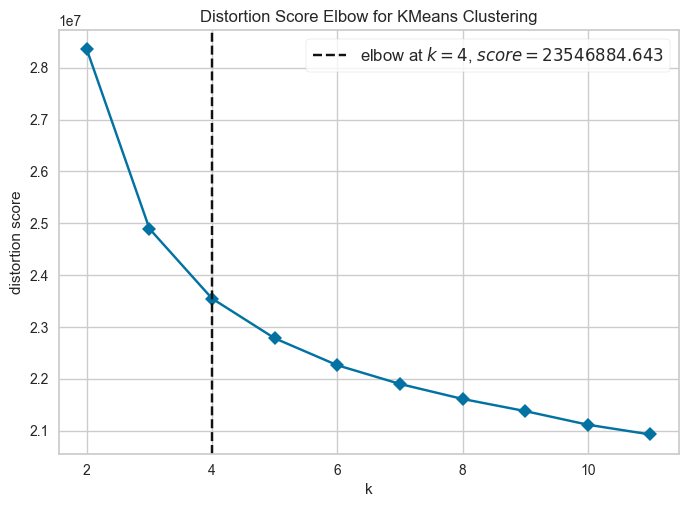

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
KClusterer = KMeans(random_state = 42)

# The Elbow visualizer
visualizer = KElbowVisualizer(KClusterer,
                              k=(2,12), # Tests for the optimal number of clusters k from 2 to 11
                              locate_elbow=True,
                              timings=False
                             )

visualizer.fit(scaled_merged_pd)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

#### The optimal number of clusters using the elbow method is *4*

#### (II) Fitting a K-Means model on the scaled data of select features using the optimal number of clusters found using the Elbow method

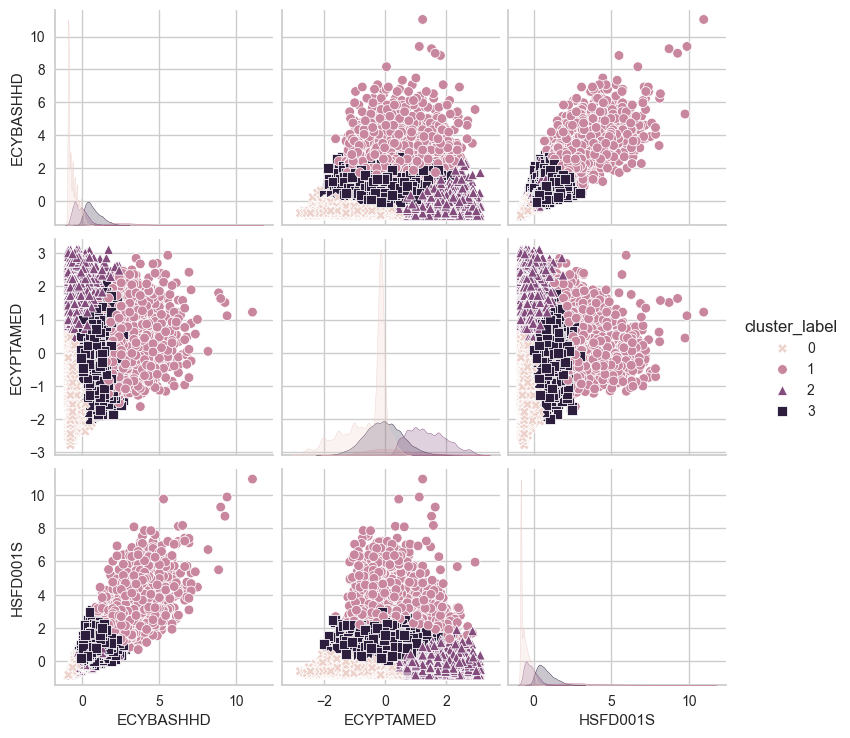

In [ ]:
# "ECYBASHHD" represents the total households
# "ECYPTAMED" represents the median age of the total population (total population by age)
# "HSFD001S" represents Food as a household expenditure
selected_columns = ["ECYBASHHD", "ECYPTAMED", "HSFD001S"] # understanding the clustering based on expenditure on necessary goods, like food


selected_columns_pd = pd.DataFrame(
    data=scaled_merged_pd[selected_columns],
    columns=selected_columns) # Create a pandas dataframe of the selected columns and their data

# Run KMeans on the optimal number of clusters found from the elbow method
KClusterer = KMeans(n_clusters=4, random_state=42)

# Fit the cluster and predict the label in one step
selected_columns_pd['cluster_label'] = KClusterer.fit_predict(selected_columns_pd)

sns.pairplot(vars=selected_columns,
             hue='cluster_label',
             markers=['X','o','^', 's'],
             data=selected_columns_pd
            )

plt.show()

#### (III) Using the K-Means method to perform clustering on the scaled data, setting random_state = 42, then visualizing it using the silhouette method to find the optimal number of clusters.

In [ ]:
# Warning: DO NOT RUN!!! EXECUTING THIS CODE BLOCK MAY TAKE HOURS.


# Drop the existing cluster labels so we only use feature data for silhouette analysis
X = selected_columns_pd.drop(columns=["cluster_label"])

for k in range(3, 8):

    print(f"\nKMeans with k = {k}")

    kmeans = KMeans(n_clusters=k, random_state=42) # Initializes the KMeans model with k clusters

    # Fit the model and get the cluster labels
    labels = kmeans.fit_predict(X)

    # Calculate and then print the silouette score of the current clustering
    score = silhouette_score(X, labels)
    print(f"Silhouette Score: {score:.3f}")

    # Initialize the Silhouette method visualizer with the KMeans model, then fit it on the data, and display it
    visualizer = SilhouetteVisualizer(kmeans)
    visualizer.fit(X.to_numpy())
    visualizer.show()

*Observed Silhouette Scores:*
- With 3 clusters (k = 3), the silhouette score is 0.337
- With 4 clusters (k = 4), the silhouette score is 0.389
- With 5 clusters (k = 5), the silhouette score is 0.447
- With 6 clusters (k = 6), the silhouette score is 0.456
- With 7 clusters (k = 7), the silhouette score is 0.448

**Since the silhouette score is the highest with 6 clusters (k = 6), the clusters are therefore the most well separated and well-defined when 6 clusters are used.**

**Thus**, the elbow method and the silhouette method do not agree since the optimal number of clusters found using the elbow method is 4, whereas the optimal number of clusters found from the silhouette method is 6.

## 1. c)

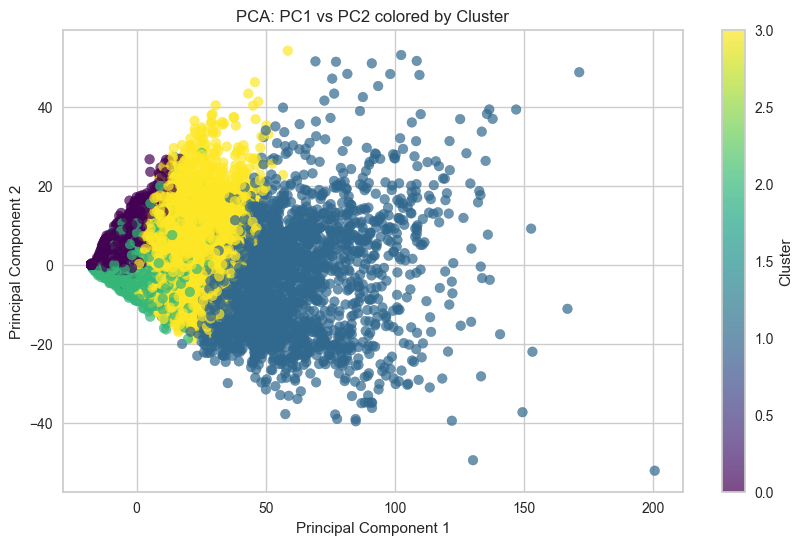

Top 3 PCs
PC1: 0.4324
PC2: 0.0345
PC3: 0.0283

Top features for PC1:
ECYMOBHPOP    0.050748
ECYTIMHPOP    0.050729
ECYPIMHPOP    0.050729
ECYHOMHPOP    0.050729
ECYMOTHPOP    0.050729
Name: PC1, dtype: float64

Top features for PC2:
ECYTIMA       0.122169
ECYMOTNOFF    0.119319
ECYTIMIMGT    0.116593
ECYAIMIM      0.116593
ECYPIMIM      0.116593
Name: PC2, dtype: float64

Top features for PC3:
ECYTENRENT    0.137559
ECYCDORENC    0.133682
ECYSTYAPT     0.129917
ECYSTYAPU5    0.121428
HSSH003       0.111853
Name: PC3, dtype: float64


In [ ]:
# Fit PCA on the scaled data
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_merged_pd)

# Plot PC1 vs PC2 with cluster labels
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1],
            c=selected_columns_pd['cluster_label'], cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: PC1 vs PC2 colored by Cluster')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Print Top 3 PCs
print("Top 3 PCs")
for i, var in enumerate(pca.explained_variance_ratio_[:3]):
    print(f"PC{i+1}: {var:.4f}")

# Extract top contributing features for the top 3 components
pca_components = pd.DataFrame(pca.components_[:3], columns=scaled_merged_pd.columns, index=["PC1", "PC2", "PC3"])

# Display top 5 contributing features for each of the components
for pc in pca_components.index:
    print(f"\nTop features for {pc}:")
    print(pca_components.loc[pc].abs().sort_values(ascending=False).head(5))


## 1. d)

c:\Users\samad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samad\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


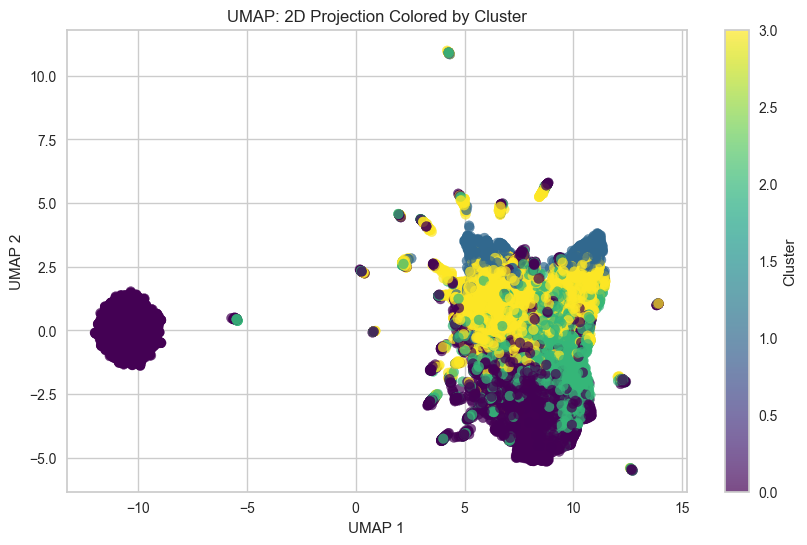

In [ ]:
# Tune UMAP parameters and fit
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_result = umap_reducer.fit_transform(scaled_merged_pd)

# Plot UMAP projection
# Colored by cluster labels
plt.figure(figsize=(10, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1],
            c=selected_columns_pd['cluster_label'], cmap='viridis', alpha=0.7)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP: 2D Projection Colored by Cluster')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


## 2.a) Elastic Net Regression

In [ ]:
# Merge and filter datasets
f = pd.merge(household_spending, demo_stats, on=["CODE","GEO"]).copy()
f = f[f['HSHNIAGG'] > 0]

# Define pension & insurance columns and features
grid_p_cols = ["HSEP001S","HSSH006","HSSH015","HSSH019",
               "HSHC022","HSHC023","HSHC024","HSHC025","HSTR032"]
feat_cols = [c for c in f.columns if c not in (["CODE","GEO"] + grid_p_cols)]

# Downcast floats to save memory
float_cols = f.select_dtypes(include=['float64']).columns
f[float_cols] = f[float_cols].astype('float32')

# Prepare target and features
y = f[grid_p_cols].sum(axis=1) / f['HSHNIAGG']
X = f[feat_cols]

del f; gc.collect()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
del X, y; gc.collect()

# Elastic Net pipeline
enet_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler()),
    ('en', ElasticNet(max_iter=10000, random_state=42))
])
enet_params = {
    'en__alpha': np.logspace(-4, 1, 8),
    'en__l1_ratio': np.linspace(0.1, 0.9, 5)
}
enet_search = RandomizedSearchCV(
    enet_pipe, enet_params,
    n_iter=10, cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=1, random_state=42
)

# Fit and evaluate
enet_search.fit(X_train, y_train)
# Convert numpy types to native Python floats for clean printing
best_params = {k: float(v) for k, v in enet_search.best_params_.items()}
print("Elastic Net best params:", best_params)
pred_en = enet_search.predict(X_test)
print("EN MSE:", mean_squared_error(y_test, pred_en),
      "R2:", r2_score(y_test, pred_en))

del X_train, X_test, y_train, y_test;
_ = gc.collect()


Elastic Net best params: {'en__l1_ratio': 0.9, 'en__alpha': 0.013894954943731374}
EN MSE: 0.0003168874320653694 R2: -2.0439866302623955e-05


## 2. b) XGBoost Regression

In [ ]:
# Rebuild full data matrix
full = pd.merge(household_spending, demo_stats, on=["CODE","GEO"]).copy()
full = full[full['HSHNIAGG'] > 0]

# Downcast floats
t_full_cols = full.select_dtypes(include=['float64']).columns
full[t_full_cols] = full[t_full_cols].astype('float32')

# Features and target
p_cols = ["HSEP001S","HSSH006","HSSH015","HSSH019",
               "HSHC022","HSHC023","HSHC024","HSHC025","HSTR032"]
feat_cols = [c for c in full.columns if c not in (["CODE", "GEO"] + p_cols)]

y = full[p_cols].sum(axis=1) / full['HSHNIAGG']
X = full[feat_cols].astype('float32')

del full; gc.collect()

from sklearn.feature_selection import VarianceThreshold
X = VarianceThreshold(threshold=0.01).fit_transform(X)

# Impute & scale
imp = SimpleImputer(strategy='median')
sc = StandardScaler(with_mean=False)
X_imp = imp.fit_transform(X)
X_scaled = sc.fit_transform(X_imp)

# Prepare DMatrix for XGBoost
dtrain = xgb.DMatrix(X_scaled, label=y)
# Hold out 20% for early stopping
holdout = int(0.2 * X_scaled.shape[0])
dtest = xgb.DMatrix(X_scaled[:holdout], label=y.iloc[:holdout])
dtrain_full = xgb.DMatrix(X_scaled[holdout:], label=y.iloc[holdout:])

# Train with early stopping
params = {"objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 4,
    "seed": 42}
bst = xgb.train(
    params,
    dtrain_full,
    num_boost_round=150,
    evals=[(dtest, 'eval')],
    early_stopping_rounds=10,
    verbose_eval=False
)
# Predict & evaluate
pred_xgb = bst.predict(xgb.DMatrix(X_scaled[:holdout]))
print("XGB MSE:", mean_squared_error(y.iloc[:holdout], pred_xgb),
      "R2:", r2_score(y.iloc[:holdout], pred_xgb))

XGB MSE: 0.00010185220162384212 R2: 0.6888654828071594


# 2b.iii - XGBoost Scatterplot and Metrics Comparison

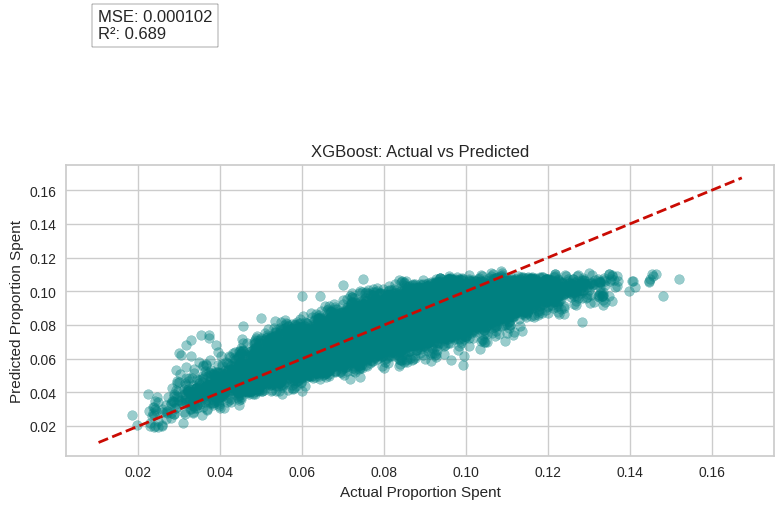

In [ ]:
#Scatterplot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y.iloc[:holdout], pred_xgb, alpha=0.4, color='teal')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel("Actual Proportion Spent")
plt.ylabel("Predicted Proportion Spent")
plt.title("XGBoost: Actual vs Predicted")
plt.grid(True)

#Metrics annotated
mse_val = mean_squared_error(y.iloc[:holdout], pred_xgb)
r2_val = r2_score(y.iloc[:holdout], pred_xgb)
plt.text(0.01, 0.25, f"MSE: {mse_val:.6f}\nR²: {r2_val:.3f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# 2c - SHAP Interpretation

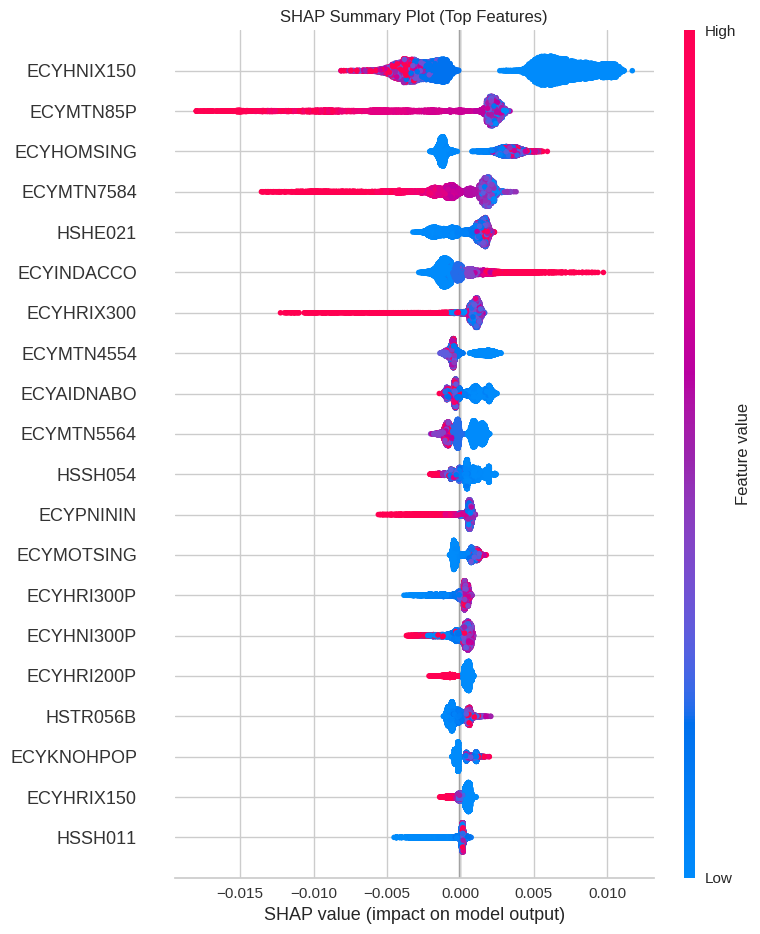

Top 5 SHAP Features:
1. ECYHNIX150
2. ECYMTN85P
3. ECYHOMSING
4. ECYMTN7584
5. HSHE021


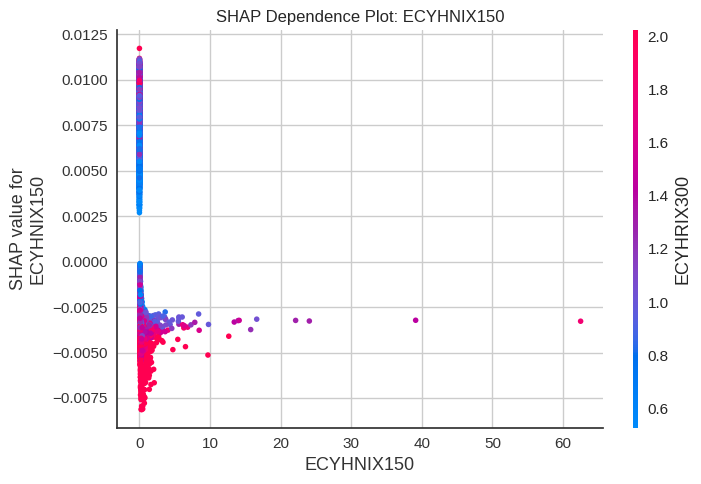

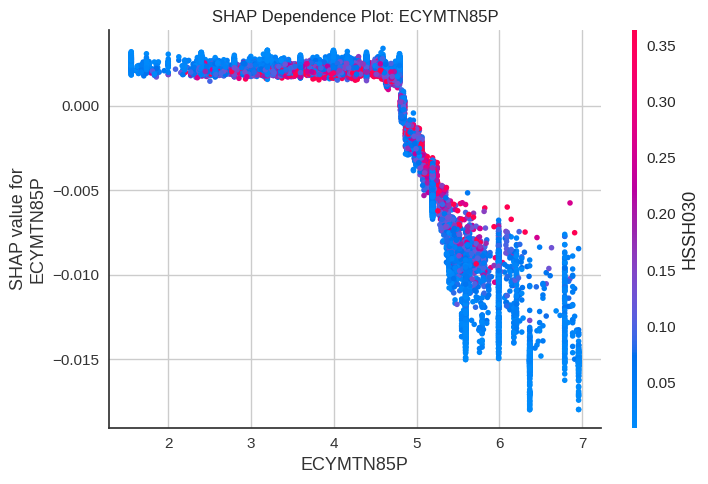

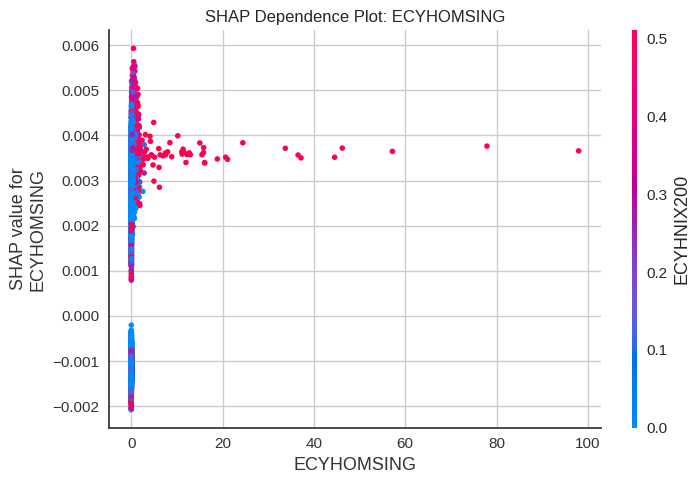

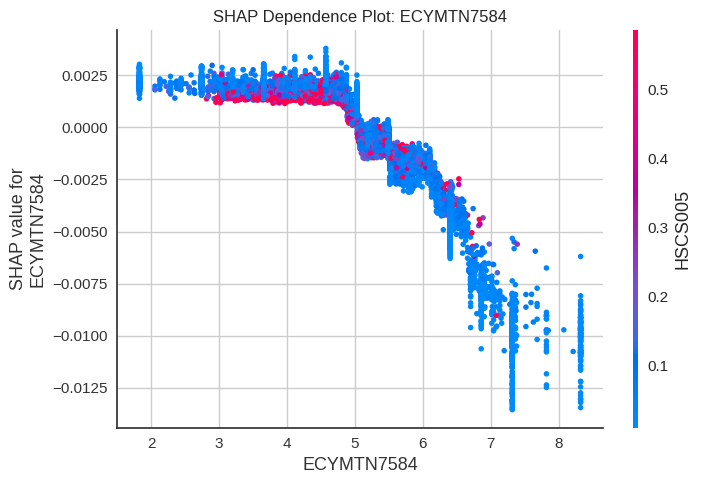

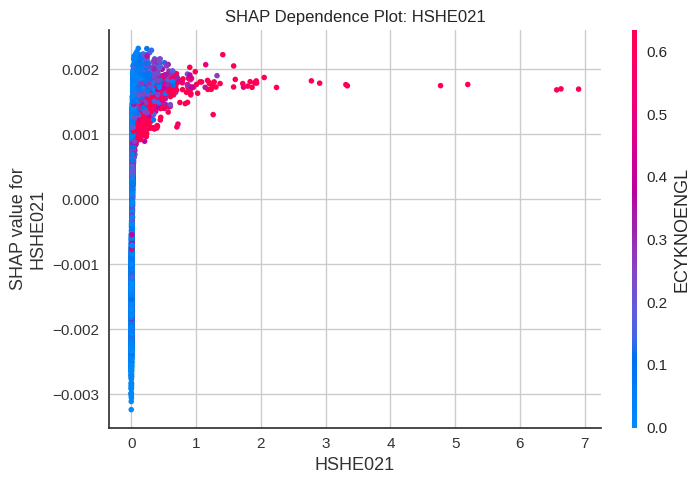

In [ ]:
#Explain model predictions using SHAP
explainer = shap.Explainer(bst)
shap_values = explainer(X_scaled[:holdout])

#Summary plot of SHAP values
shap.summary_plot(shap_values, features=X_scaled[:holdout], feature_names=feat_cols, show=False)
plt.title("SHAP Summary Plot (Top Features)")
plt.tight_layout()
plt.show()

#Get mean absolute SHAP values to find top 5 features
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
top5_indices = np.argsort(mean_abs_shap)[-5:][::-1]
top5_features = [feat_cols[i] for i in top5_indices]

print("Top 5 SHAP Features:")
for i, feat in enumerate(top5_features):
    print(f"{i+1}. {feat}")

#SHAP dependence plots for each top feature
for feat in top5_features:
    shap.dependence_plot(feat, shap_values.values, X_scaled[:holdout], feature_names=feat_cols, show=False)
    plt.title(f"SHAP Dependence Plot: {feat}")
    plt.tight_layout()
    plt.show()